<a href="https://colab.research.google.com/github/kibbm/ResNet-Tensorflow/blob/master/ResNet101V2_Binary_Image_Classification_using_Keras(v_1009%EC%98%A4%EC%A0%8411).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** 구글 드라이브 없는 버전입니다(v_1009오전11)

# Kaggle Challenge : Dogs-vs-Cats - Binary Image Classification using Keras
해당 포스트는 [Kaggle  Dogs-vs-Cats challenge](https://www.kaggle.com/c/dogs-vs-cats) 해결하기위해 만들었으며, 여러 가지 자료들을 참고하여 만든 포스트 입니다.


*   개발 환경 : google colab, Python3, Tensorflow, Keras
*   실험 모델 : VGG16(Transfer Learning)
*   실험에 쓰인 데이터 : Kaggle Dogs vs Cats challenge
*   Test {개: 1,000, 고양이: 1,000} (총 2,000개)
*   Training {개: 5,000, 고양이: 5,000} (총 10,000개)
*   Validation {개: 2,500, 고양이: 2,500} (총 5,000개)
*   IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 224, 224, 3, 32

In [1]:
!nvidia-smi

Fri Oct  9 03:06:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

실험에 필요한 이미지 파일 다운 & /content 에 압축풀기

In [2]:
# wget 또는 git
# 오류 시 https://github.com/4nchez/Dataset/blob/main/cats_vs_dogs_images_small.zip 에서 다운
!wget https://github.com/4nchez/Dataset/raw/main/cats_vs_dogs_images_small.zip #유닉스 wget 명령어 이용
!git clone https://github.com/4nchez/Dataset.git #git 명령어 이용 (git설치 하면, Windows, Unix, Mac 다 사용가능)

--2020-10-09 03:06:23--  https://github.com/4nchez/Dataset/raw/main/cats_vs_dogs_images_small.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/4nchez/Dataset/main/cats_vs_dogs_images_small.zip [following]
--2020-10-09 03:06:23--  https://media.githubusercontent.com/media/4nchez/Dataset/main/cats_vs_dogs_images_small.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548537342 (523M) [application/zip]
Saving to: ‘cats_vs_dogs_images_small.zip’

cats_vs_dogs_images 100%[===================>] 523.12M   255MB/s    in 2.1s    

2020-10-09 03:06:34 (255 MB/s) - ‘cats_vs_dogs_images_

In [3]:
!rm -rf Dataset/
!rm -rf test/
!rm -rf training/
!rm -rf validation/

In [4]:
import os, shutil
import zipfile

local_zip = '/content/cats_vs_dogs_images_small.zip' #wget 명령어로 받았을 때
# local_zip = '/content/Dataset/cats_vs_dogs_images_small.zip' #git 명어령로 받았을 때
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/content')
zip_ref.close()

Extracting all images...


## 실험에 쓰일 데이터 파일 연결

In [5]:
import sys, os, random
import numpy as np
import tensorflow as tf
import keras
print('Using Tensorflow version ', tf.__version__)
print('Using keras version ', keras.__version__)
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0
Using keras version  2.4.3


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
images_root = "/content"
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 224, 224, 3, 32

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

# Default ResNet101


In [23]:
#vgg_base = keras.applications.VGG16(include_top=True, weights='imagenet',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
#x = Dense(1, activation='sigmoid', name='predictions')(vgg_base.layers[-2].output)
#vgg_base.trainable = False
#model = Model(vgg_base.input,x)

res_base = keras.applications.resnet_v2.ResNet101V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
x = Dense(1, activation='sigmoid', name='predictions')(res_base.layers[-2].output)
res_base.trainable = False
model = Model(res_base.input,x)

model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',#mse, binary_crossentropy
                  metrics=['acc'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [24]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 63s 202ms/step - loss: 0.1842 - acc: 0.9427 - val_loss: 0.0892 - val_acc: 0.9740
Epoch 2/50
312/312 [==============================] - 63s 203ms/step - loss: 0.0666 - acc: 0.9804 - val_loss: 0.0613 - val_acc: 0.9790
Epoch 3/50
312/312 [==============================] - 64s 205ms/step - loss: 0.0495 - acc: 0.9840 - val_loss: 0.0526 - val_acc: 0.9816
Epoch 4/50
312/312 [==============================] - 61s 197ms/step - loss: 0.0418 - acc: 0.9864 - val_loss: 0.0474 - val_acc: 0.9830
Epoch 5/50
312/312 [==============================] - 60s 194ms/step - loss: 0.0372 - acc: 0.9872 - val_loss: 0.0446 - val_acc: 0.9840
Epoch 6/50
312/312 [==============================] - 59s 190ms/step - loss: 0.0339 - acc: 0.9888 - val_loss: 0.0426 - val_acc: 0.9840
Epoch 7/50
312/312 [==============================] - 60s 191ms/step - loss: 0.0311 - acc: 0.9896 - val_loss: 0.0416 - val_acc: 0.9856
Epoch 8/50
312/312 [==============================] - 5

In [25]:
def show_plots(history, plot_title=None, fig_size=None):
    """ Useful function to view plot of loss values & accuracies across the various epochs
        Works with the history object returned by the train_model(...) call """
    assert type(history) is dict

    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['acc']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    if plot_title is not None:
        plt.suptitle(plot_title)

    plt.show()
    plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals
def save_keras_model(model, base_file_name, save_dir=os.path.join('.','keras_models')):
    """ save the model structure to JSON & weights to HD5 """    
    # check if save_dir exists, else create it
    if not os.path.exists(save_dir):
        try:
            os.mkdir(save_dir)
        except OSError as err:
            print("Unable to create folder {} to save Keras model. Can't continue!".format(save_dir))
            raise err
            
    # model structure is saved to $(save_dir)/base_file_name.json
    # weights are saved to $(save_dir)/base_file_name.h5
    model_json = model.to_json()
    json_file_path = os.path.join(save_dir, (base_file_name + ".json"))
    h5_file_path = os.path.join(save_dir, (base_file_name + ".h5"))            

    with open(json_file_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5\n",
    model.save_weights(h5_file_path)
    print("Saved model to files %s and %s" % (json_file_path, h5_file_path))

def load_keras_model(base_file_name, load_dir=os.path.join('.', 'keras_models')):
    """ loads model structure & weights from previously saved state """
    # model structure is loaded $(load_dir)/base_file_name.json
    # weights are loaded from $(load_dir)/base_file_name.h5

    from tensorflow.keras.models import model_from_json

    # load model from save_path
    loaded_model = None
    json_file_path = os.path.join(load_dir, (base_file_name + ".json"))
    h5_file_path = os.path.join(load_dir, (base_file_name + ".h5"))

    if os.path.exists(json_file_path) and os.path.exists(h5_file_path):
        with open(json_file_path, "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = model_from_json(loaded_model_json)
            loaded_model.load_weights(h5_file_path)
        print("Loaded model from files %s and %s" % (json_file_path, h5_file_path))
    else:
        msg = "Model file(s) not found in %s! Expecting to find %s and %s in this directory." % (
            load_dir, (base_file_name + ".json"), (base_file_name + ".h5"))
        raise IOError(msg)
    return loaded_model

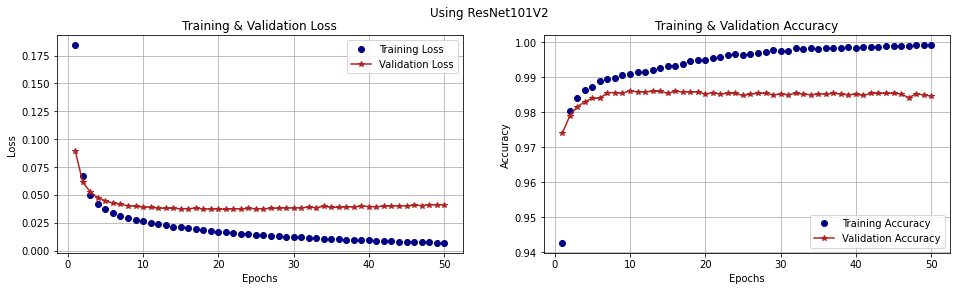

In [26]:
show_plots(hist.history, plot_title='Using ResNet101V2')

In [27]:
# 성능 평가
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 42s 134ms/step - loss: 0.0064 - acc: 0.9993
Training data  -> loss: 0.006, acc: 0.999
156/156 [==============================] - 21s 134ms/step - loss: 0.0412 - acc: 0.9846
Cross-val data -> loss: 0.041, acc: 0.985
62/62 [==============================] - 8s 132ms/step - loss: 0.0374 - acc: 0.9904
Testing data   -> loss: 0.037, acc: 0.990


In [29]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(hist.history, file_pi)

import pandas as pd
MODEL_SAVE_DIR='/content'
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(hist.history) 

# save to json:  
hist_json_file = MODEL_SAVE_DIR +'/파일명.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = MODEL_SAVE_DIR +'/파일명.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


save_keras_model(model, '파일명', MODEL_SAVE_DIR)
#del res_base
#del model

Saved model to files /content/파일명.json and /content/파일명.h5
